### Import of the required libraries

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import RandomOverSampler

from collections import Counter

from tensorflow import keras

### Load the data

In [3]:
data = pd.read_csv("./data/churn.csv")

## Feature Engineering

### Remove unused columns

In [4]:
data_prepared = data.drop(["RowNumber", "CustomerId", "Surname", "Exited"], axis=1)
y = data["Exited"]

data_prepared

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


### Create pipeline for scalling and one-hot encoding

In [5]:
scaler_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

In [6]:
onehot_pipeline = Pipeline([ 
    ("onehot", OneHotEncoder())
])

In [7]:
full_transformer = ColumnTransformer([
    ("pass", "passthrough", ["HasCrCard", "IsActiveMember"]),
    ("scaler", scaler_pipeline, ["Age", "CreditScore", "Balance", "EstimatedSalary", "Tenure", "NumOfProducts"]),
    ("onehot", onehot_pipeline, ["Geography", "Gender"])
])

### The last 500 records are for the validation set

In [8]:
data_final = data_prepared[:9500]
y_final = y[:9500]
 
data_validation = data_prepared[9500:]
y_validation = y[9500:]

### Splitting the dataset in data and label

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_final, y_final, test_size=0.2, shuffle=True, random_state=42)

### Oversampling the minority class
We need to do an oversampling because the exited class is underrepresented

In [32]:
oversampler = RandomOverSampler(random_state=42, sampling_strategy="auto")
X_train_resample, y_train_resample = oversampler.fit_resample(X_train, y_train)

print(Counter(y_train_resample))
print(X_train_resample.shape)
print(y_train_resample.shape)

Counter({0: 6055, 1: 6055})
(12110, 10)
(12110,)


In [11]:
X_train_onehot_scaled = full_transformer.fit_transform(X_train_resample)
X_test_onehot_scaled = full_transformer.fit_transform(X_test)

print(X_train_onehot_scaled.shape)
print(X_test_onehot_scaled.shape)

(12110, 13)
(1900, 13)


## Train the Neuronal Network

In [122]:
nn_model = keras.models.Sequential([
    keras.layers.Input(shape=X_train_onehot_scaled[-1].shape),
    keras.layers.Dense(64, activation=keras.activations.relu,
                        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(32, activation=keras.activations.relu,
                        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(16, activation=keras.activations.relu,
                        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(8, activation=keras.activations.relu,
                        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(1, activation=keras.activations.sigmoid,
                        kernel_regularizer=keras.regularizers.l2(0.01))
])

In [123]:
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss=keras.losses.BinaryCrossentropy(), 
    metrics=["accuracy"])

In [124]:
history = nn_model.fit(X_train_onehot_scaled, y_train_resample, validation_data=(X_test_onehot_scaled, y_test), epochs=15)

Epoch 1/15
379/379 [==============================] - 1s 2ms/step - loss: 1.5459 - accuracy: 0.5410 - val_loss: 1.5004 - val_accuracy: 0.3384
Epoch 2/15
379/379 [==============================] - 1s 1ms/step - loss: 1.3097 - accuracy: 0.6463 - val_loss: 1.3152 - val_accuracy: 0.5184
Epoch 3/15
379/379 [==============================] - 1s 1ms/step - loss: 1.1395 - accuracy: 0.7073 - val_loss: 1.1570 - val_accuracy: 0.6179
Epoch 4/15
379/379 [==============================] - 1s 1ms/step - loss: 1.0104 - accuracy: 0.7316 - val_loss: 1.0507 - val_accuracy: 0.6311
Epoch 5/15
379/379 [==============================] - 1s 1ms/step - loss: 0.9134 - accuracy: 0.7391 - val_loss: 0.9615 - val_accuracy: 0.6621
Epoch 6/15
379/379 [==============================] - 1s 1ms/step - loss: 0.8393 - accuracy: 0.7463 - val_loss: 0.9062 - val_accuracy: 0.6616
Epoch 7/15
379/379 [==============================] - 1s 1ms/step - loss: 0.7826 - accuracy: 0.7530 - val_loss: 0.8570 - val_accuracy: 0.6758
Epoch 

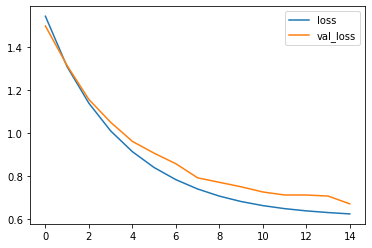

In [125]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

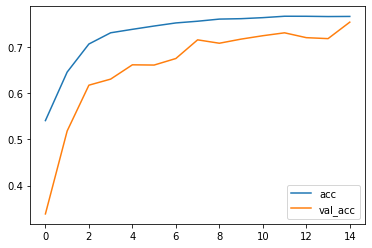

In [126]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

## Predict the validation dataset

In [127]:
X_validation_onehot_scaled = full_transformer.fit_transform(data_validation)
X_validation_onehot_scaled.shape

(500, 13)

In [128]:
prediction = nn_model.predict(X_validation_onehot_scaled).ravel() > 0.5
y_pred = [int(p) for p in prediction]

In [133]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.70      0.81       413
           1       0.37      0.84      0.51        87

    accuracy                           0.72       500
   macro avg       0.66      0.77      0.66       500
weighted avg       0.85      0.72      0.75       500



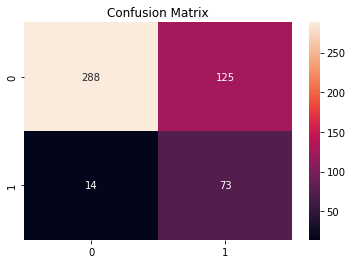

In [134]:
con_matrix = confusion_matrix(y_validation, y_pred)
sns.heatmap(con_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()